<a href="https://colab.research.google.com/github/pcashman21/feral-cat-census/blob/main/notebooks/yolo/extract_from_yolo_instance_segmentation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import zipfile
!unzip unusable.zip

In [4]:
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
PATH_TO_IMAGES = '/content/unusable/*.jpeg'

In [ ]:
import glob
image_paths = []
# get all image paths in dataset to process
for path in glob.glob(PATH_TO_IMAGES):
    image_paths.append(path)
# sort image_path
image_paths.sort()
image_paths

In [8]:
SEGMENTED_FILES_FOLDER = '/content/unusable-segmented'
!mkdir $SEGMENTED_FILES_FOLDER

In [ ]:
validation_image_path = '/content/gdrive/MyDrive/Cat images/feral-cat-segmentation.v1i.yolov8/valid/images/group0049_jpeg.rf.c646c039e92fa8f3bfd94ec8420953f1.jpg'

In [ ]:
# This code extracts each object from an image using its segmentation mask predicted by the YOLO v8 feral cat segmentation model.
# This code was adapted (slightly) from the code in the YOLO v8 documentation, which can be found at
# https://docs.ultralytics.com/guides/isolating-segmentation-objects/#recipe-walk-through.  The numbers in parentheses refer to steps
# and explanations in that documentation.

from pathlib import Path

import cv2 as cv
import numpy as np
from ultralytics import YOLO
from PIL import Image

trained_model = YOLO('/content/gdrive/MyDrive/Cat images/models/feral-cat-segmentation.v1i.yolov8/200-epochs-/weights/best.pt') #(4)!
# validation_image = Image.open(validation_image_path)
res = trained_model.predict(image_paths, conf=CONFIDENCE_THRESHOLD, iou=IOU_THRESHOLD) #(3)!

# iterate detection results (5)
for r in res:
    img = np.copy(r.orig_img)
    img_name = Path(r.path).stem

    # iterate each object contour (6)
    for ci,c in enumerate(r):
        label = c.names[c.boxes.cls.tolist().pop()]

        b_mask = np.zeros(img.shape[:2], np.uint8)

        # Create contour mask (1)
        contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
        _ = cv.drawContours(b_mask, [contour], -1, (255, 255, 255), cv.FILLED)

        # Choose one:

        # OPTION-1: Isolate object with black background
        # mask3ch = cv.cvtColor(b_mask, cv.COLOR_GRAY2BGR)
        # isolated = cv.bitwise_and(mask3ch, img)

        # OPTION-2: Isolate object with transparent background (when saved as PNG)
        isolated = np.dstack([img, b_mask])

        # OPTIONAL: detection crop (from either OPT1 or OPT2)
        x1, y1, x2, y2 = c.boxes.xyxy.cpu().numpy().squeeze().astype(np.int32)
        iso_crop = isolated[y1:y2, x1:x2]

        # Save isolated object to file
        _ = cv.imwrite(f'{SEGMENTED_FILES_FOLDER}/{img_name}_{label}-{ci}.png', iso_crop)

In [ ]:
import glob
import matplotlib.image as img
import matplotlib.pyplot as plt
image_paths = []
# get all image paths for extracted masks and display the extracted cat
for path in glob.glob('/content/group0049_jpeg.rf.c646c039e92fa8f3bfd94ec8420953f1_cat-*.png'):
    image_paths.append(path)
image_paths.sort()
image_paths


['/content/group0049_jpeg.rf.c646c039e92fa8f3bfd94ec8420953f1_cat-0.png',
 '/content/group0049_jpeg.rf.c646c039e92fa8f3bfd94ec8420953f1_cat-1.png',
 '/content/group0049_jpeg.rf.c646c039e92fa8f3bfd94ec8420953f1_cat-2.png',
 '/content/group0049_jpeg.rf.c646c039e92fa8f3bfd94ec8420953f1_cat-3.png',
 '/content/group0049_jpeg.rf.c646c039e92fa8f3bfd94ec8420953f1_cat-4.png',
 '/content/group0049_jpeg.rf.c646c039e92fa8f3bfd94ec8420953f1_cat-5.png']

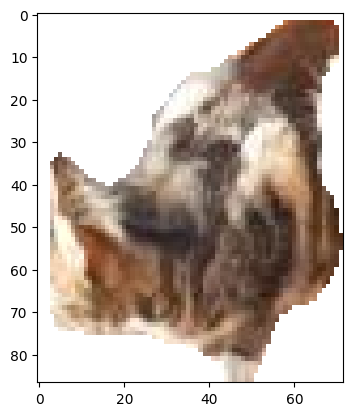

In [ ]:
#for i in range(len(image_paths)):
im = img.imread(image_paths[5])
plt.imshow(im)